# Introduction to Machine Learning for Streaming Data

This notebook introduces some basic concepts concerning Machine Learning for Streaming Data (or Data Streams) using CapyMOA. 
* There are more detailed notebooks and documentation available, our goal here is just present some high-level functions and demonstrate a subset of CapyMOA's functionalities. 
* For simplicity, we simulate data streams in the following examples using datasets and employing synthetic generators.

---

### CapyMOA 

* More information about CapyMOA can be found in: [https://github.com/adaptive-machine-learning/CapyMOA](https://github.com/adaptive-machine-learning/CapyMOA)

* _If you find CapyMOA useful, considering starring the project and joining the Discord channel!_

* **KDD 2024 tutorial** by [Heitor Murilo Gomes](https://heitorgomes.com/) and [Albert Bifet](https://albertbifet.com/). Barcelona, Spain (26/08/2024), 

**Code examples are based on CapyMOA v0.7.0 as of 08/08/2024**

## 1. Learning cycle

* Learning from data streams tradicionally assumes instances are available in an incremental fashion and labels become available before a new instance becomes available (immediate labelling assumption)
* It is common to simulate this behavior using a **while loop**, often referred to as a **test-then-train loop** (or **cumulative loop**) which contains 4 distinct steps:
    1. Fetches the next instance from the stream
    2. Makes a prediction
    3. Train the model with the instance
    4. Update a mechanism to keep track of metrics

**Some remarks about test-then-train loop**:
* We must not train before testing, meaning that steps 2 and 3 should not be interchanged, as this would invalidate our interpretation concerning how the model performs on unseen data, leading to unreliable evaluations of its efficacy. 
* Steps 3 and 4 can be completed in any order without altering the result. 
* What if labels are not immediately available? Then you might want to read about delayed labeling and partially labeled data, see [A Survey on Semi-supervised Learning for Delayed Partially Labelled Data Streams](https://dl.acm.org/doi/full/10.1145/3523055)
* More information on classification for data streams is available on section **2.2 Classification** from [Machine Learning for Data Streams](https://moa.cms.waikato.ac.nz/book-html/) book


In [1]:
from capymoa.datasets import Electricity
from capymoa.evaluation import ClassificationEvaluator
from capymoa.classifier import OnlineBagging

elec_stream = Electricity()
ob_learner = OnlineBagging(schema=elec_stream.get_schema(), ensemble_size=5)
# Evaluators in capymoa calculate several metrics at once
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    prediction = ob_learner.predict(instance)
    ob_learner.train(instance)
    ob_evaluator.update(instance.y_index, prediction)

print(f"Accuracy: {ob_evaluator.accuracy()}")

Accuracy: 82.06656073446328


## 2. Evaluation

* If our goal is just to evaluate learners it would be tedious to keep writing **test-then-train loops**. 
Thus, it makes sense to encapsulate that loop inside **high-level evaluation functions**. 

* Furthermore, sometimes we are interested in **cumulative metrics** (i.e. interleaved test-then-train) and sometimes we care about metrics **windowed metrics** (i.e. prequential). For example, if we want to know how accurate our model is so far, considering all the instances it has seen, then we would look at its **cumulative metrics**. However, we might also be interested in how well the model is every **n** number of instances, so that we can, for example, identify periods in which our model was really struggling to produce correct predictions. 

* In this example, we use the ```prequential_evaluation``` function to evaluate a `HoeffdingTree` classifier on the `Electricity` data stream. ```prequential_evaluation``` provides us with both the **cumulative** and the **windowed** metrics. 


* Some remarks:
    * If you want to know more about other **high-level evaluation functions**, **evaluators**, or which **metrics** are available, check the **01_evaluation** notebook, see [capymoa tutorials](https://capymoa.org/tutorials.html)
    * The **results** from evaluation functions such as **prequential_evaluation** follows a standard see (PrequentialResults)[https://capymoa.org/api/modules/capymoa.evaluation.results.PrequentialResults.html]
    * Sometimes authors refer to the **cumulative** metrics as **test-then-train** metrics, such as **test-then-train accuracy** (or TTT accuracy for short). Often they are all referring to the same evaluation approach.
    * Shouldn't we recreate the stream object ```elec_stream```? No, `prequential_evaluation()`, by default, automatically ```restart()``` streams when they are reused.

In [2]:
from capymoa.evaluation import prequential_evaluation
from capymoa.classifier import HoeffdingTree

ht = HoeffdingTree(schema=elec_stream.get_schema(), grace_period=50)

# Obtain the results from the high-level function. 
    # Note that we need to specify a window_size as we obtain both windowed and cumulative results. 
    # The results from a high-level evaluation function are represented as a PrequentialResults object
results_ht = prequential_evaluation(stream=elec_stream, learner=ht, window_size=4500, max_instances=50000)

print(f"Cumulative accuracy = {results_ht.cumulative.accuracy()}, wall-clock time: {results_ht.wallclock()}")

# The windowed results are conveniently stored in a pandas DataFrame. 
display(results_ht.windowed.metrics_per_window())

Cumulative accuracy = 81.6604872881356, wall-clock time: 0.2669870853424072


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,4500.0,87.777778,74.440796,24.242424,68.856172,87.222016,84.550562,89.889706,87.149807,84.078212,90.221402,87.294344,85.028249,89.560440
1,9000.0,83.666667,66.963969,2.649007,64.458414,83.538542,81.657100,85.279391,83.752489,84.373388,83.131589,83.325685,79.110251,87.541118
2,13500.0,85.644444,71.282626,2.269289,70.009285,85.663875,85.304823,85.968723,85.634554,83.780161,87.488948,85.693216,86.886006,84.500427
3,18000.0,81.977778,61.953129,-25.154321,57.021728,81.463331,76.168087,85.510095,82.841248,85.488127,80.194370,80.130502,68.680445,91.580559
4,22500.0,86.177778,70.202882,13.370474,64.719229,85.389296,80.931944,89.159986,86.648480,88.058706,85.238254,84.166185,74.872377,93.459993
5,27000.0,78.088889,53.951820,-72.377622,47.272727,77.186522,71.634062,82.150615,77.962693,77.521793,78.403594,76.425652,66.577540,86.273764
6,31500.0,79.066667,55.619360,-71.897810,46.263548,77.829775,72.504378,83.100108,78.081099,74.237896,81.924301,77.580064,70.849971,84.310157
7,36000.0,74.955556,49.002474,-89.411765,37.354086,74.661963,70.719667,78.120753,74.256346,66.390244,82.122449,75.072035,75.653141,74.490929
8,40500.0,74.555556,50.130218,-71.664168,41.312148,76.116886,74.818562,74.286998,76.196815,65.523883,86.869748,76.037125,87.186058,64.888191
9,45000.0,84.377778,68.535062,-0.428571,68.390288,84.268304,82.949309,85.585401,84.249034,82.648623,85.849445,84.287584,83.252191,85.322976


### 3. Comparing results

* CapyMOA provides ```plot_windowed_results``` as an easy visualization function for quickly comparing **windowed metrics**
* In the example below, we create four classifiers:
  * `HoeffdingAdaptiveTree` using MOA
  * `HoeffdingTree` (native wrapper)
  * `AdaptiveRandomForest` (native wrapper)
  * `PassiveAggressiveClassifier` using Scikit-learn
* Results are plotted using ```plot_windowed_results```

HAT accuracy = 84.68617584745762 wallclock: 0.7030410766601562
HT accuracy = 81.6604872881356 wallclock: 0.25443196296691895
ARF accuracy = 81.90766242937853 wallclock: 2.9830100536346436
PA accuracy = 85.2445268361582 wallclock: 9.287315845489502


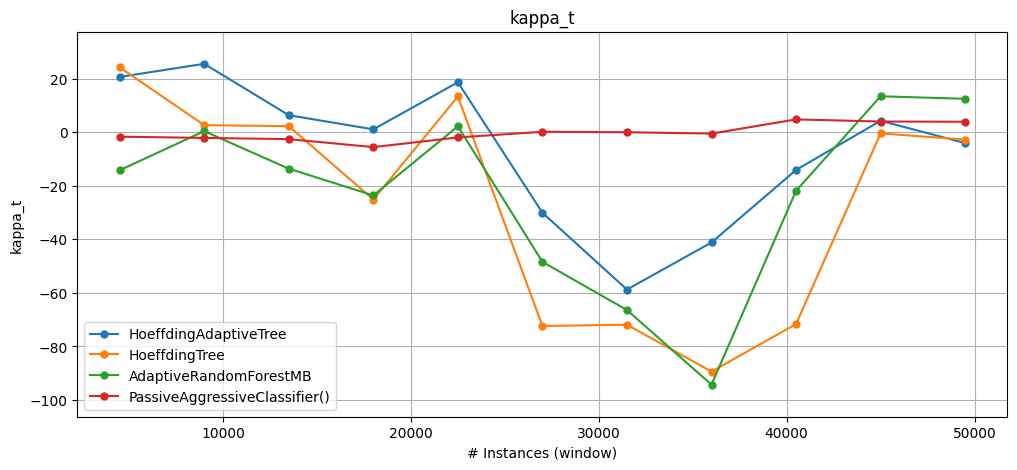

In [3]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.base import MOAClassifier, SKClassifier
from moa.classifiers.trees import HoeffdingAdaptiveTree
from sklearn.linear_model import PassiveAggressiveClassifier
from capymoa.classifier import HoeffdingTree
from capymoa.classifier import AdaptiveRandomForestClassifier


HT = HoeffdingTree(schema=elec_stream.get_schema(), grace_period=50)
ARF = AdaptiveRandomForestClassifier(schema=elec_stream.get_schema(), ensemble_size=10, number_of_jobs=4)
# Users a generic wrapper for a MOA classifier
HAT = MOAClassifier(schema=elec_stream.get_schema(), moa_learner=HoeffdingAdaptiveTree, CLI="-g 50")
# Uses a generic wrapper for a scikit-learn classifier
PA = SKClassifier(sklearner=PassiveAggressiveClassifier(), schema=elec_stream.get_schema())

results_HAT = prequential_evaluation(stream=elec_stream, learner=HAT, window_size=4500)
results_HT = prequential_evaluation(stream=elec_stream, learner=HT, window_size=4500)
results_ARF = prequential_evaluation(stream=elec_stream, learner=ARF, window_size=4500)
results_PA = prequential_evaluation(stream=elec_stream, learner=PA, window_size=4500)

# Comparing models based on their cumulative accuracy
print(f"HAT accuracy = {results_HAT.cumulative.accuracy()} wallclock: {results_HAT.wallclock()}")
print(f"HT accuracy = {results_HT.cumulative.accuracy()} wallclock: {results_HT.wallclock()}")
print(f"ARF accuracy = {results_ARF.cumulative.accuracy()} wallclock: {results_ARF.wallclock()}")
print(f"PA accuracy = {results_PA.cumulative.accuracy()} wallclock: {results_PA.wallclock()}")

# Plotting the results. Note that we ovewrote the ylabel, but that doesn't change the metric. 
plot_windowed_results(results_HAT, results_HT, results_ARF, results_PA, metric="kappa_t", xlabel="# Instances (window)")
# Tip: try kappa_t as a metric as well! 

## 4. Data representation

* In CapyMOA, `Stream` objects have a clear API and and considered a source of infinite data. 
* CapyMOA data reprensentation takes the form of `Instances` (X) and `LabeledInstances` (X,y).
* Furthermore, CapyMOA introduces the notion of `Schema` which includes meta-data about the data presented by a `Stream`
* In CapyMOA, we also include a `Datasets` class to provide access to commonly used datasets like `Electricity` and `Covertype`


# Exercises (Introduction)

## 1. Improve predictive performance.

Using `RTG_2abrupt` stream try to improve the predictive performance of the Hoeffding Tree algorithm by changing its hyperparameters (See the Hoeffding Tree's [API reference](https://capymoa.org/api/modules/capymoa.classifier.HoeffdingTree.html)). 


**More details/Tips**
* The synthetic stream snapshot `RTG_2abrupt` includes 100,000 instances. 
* To plot the same learner under different names, you can override the `learner` attribute in the results from `prequential_evaluation` as shown in the sample code below.

Cumulative Accuracy: 57.677


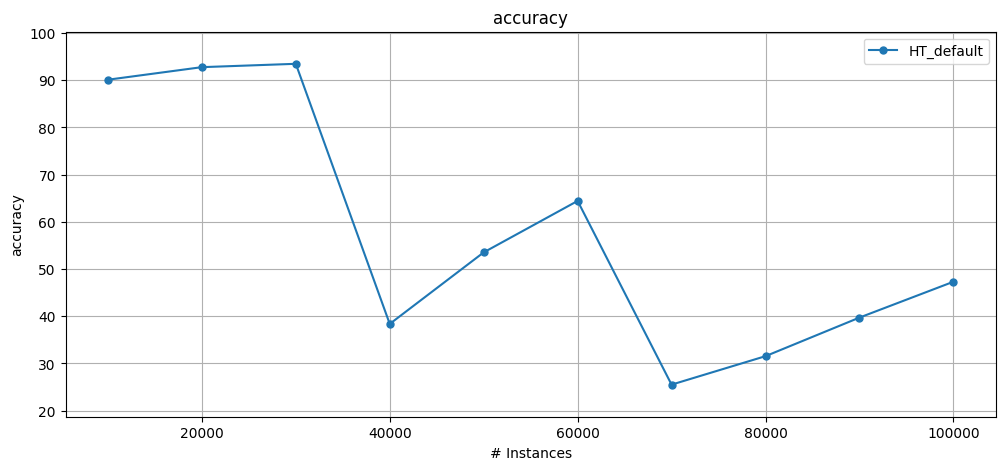

In [4]:
from capymoa.datasets import RTG_2abrupt
from capymoa.classifier import HoeffdingTree
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results


rtg2_stream = RTG_2abrupt()
ht_default = HoeffdingTree(schema=rtg2_stream.get_schema())

results = prequential_evaluation(stream=rtg2_stream, learner=ht_default, window_size=10000)
results.learner = 'HT_default'

print(f'Cumulative Accuracy: {results.cumulative.accuracy()}')
plot_windowed_results(results, metric='accuracy')

## 2. Assessing results using different metrics and approaches

Assess the results for the experiments below using the `Electricity` stream below using different metrics. You may also want to verify the windowed versions of the metrics (either in a plot or on a list/dataframe). 

What can be observed when comparing the results from a complex model such as ARF and the NoChange classifier using a metric like `kappa_t`? 

**More details/Tips**
* You can use the `cumulative` and `windowed` objects to access the metrics associated with a particular result from `prequential_evaluation`
* The available metrics are accessible through `metrics_header()` as shown in the example below

In [5]:
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import Electricity
from capymoa.classifier import NaiveBayes, NoChange, AdaptiveRandomForestClassifier

elec_stream = Electricity()
nb = NaiveBayes(schema=elec_stream.get_schema())
no_change = NoChange(schema=elec_stream.get_schema())
arf = AdaptiveRandomForestClassifier(schema=elec_stream.get_schema(), number_of_jobs=4)

results_nb = prequential_evaluation(stream=elec_stream, learner=nb, window_size=4500)
results_no_change = prequential_evaluation(stream=elec_stream, learner=no_change, window_size=4500)
results_arf = prequential_evaluation(stream=elec_stream, learner=arf, window_size=4500)

# The available metrics:
results_nb.metrics_header()

['instances',
 'accuracy',
 'kappa',
 'kappa_t',
 'kappa_m',
 'f1_score',
 'f1_score_0',
 'f1_score_1',
 'precision',
 'precision_0',
 'precision_1',
 'recall',
 'recall_0',
 'recall_1']

In [6]:
from capymoa.evaluation.visualization import plot_windowed_results

# print(f'[Cumulative] Accuracy: {...}')
# print(f'[Windowed] Accuracy: {...}')

# plot_windowed_results(...)